## 分形布朗运动


#### 波的叠加

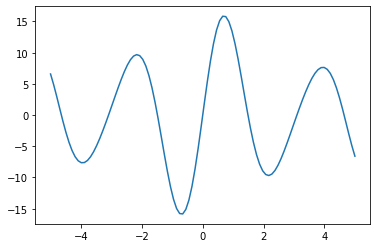

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

x = np.linspace(-5, 5, 100)
y = np.sin(x)
y += np.sin(x * 2.1) * 4.5
y += np.sin(x * 1.72) * 4.0 
y += np.sin(x * 2.221) * 5.0 
y += np.sin(x * 3.1122) * 2.5 

plt.plot(x, y)

#### fract brownian motion

- 对一个波进行如下处理：增加频率，减小振幅；
- 然后将处理后的波叠加在原始的波上
- 重复上述过程，最终就能得到 fBM

fBM 的波有什么特点：

- 如果增加迭代的次数，波的细节也会增加
- 如果放大看波的某个地方，会发现它和其他地方有些相似。这时候自相似，也就是「分形」的特性

简单地对正弦波进行叠加：

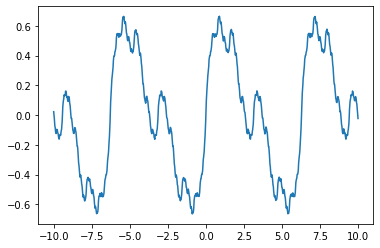

In [9]:
import numpy as np
import matplotlib.pyplot as plt 

lacunarity = 2.0    # 频率变化的系数
gain = 0.5          # 增益：幅度变化的系数

frequency = 1.0     # 波的频率
amplitude = 0.5     # 波的幅度

x = np.linspace(-10, 10, 1000)
y = np.repeat(0.0, 1000)
for i in range(16):
    y += amplitude * np.sin(x * frequency)
    frequency *= lacunarity
    amplitude *= gain

plt.plot(x, y)

#### 二维情形的 fBM

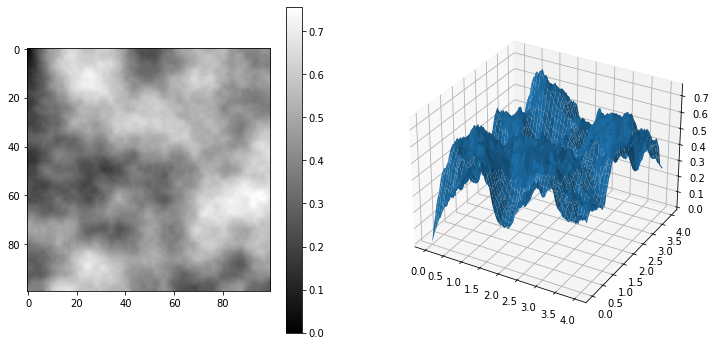

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap

OCTAVES = 8     # 迭代的次数

def fract(x):
    return x - np.floor(x)

def rand1(x, y):
    return fract(np.sin(x * 12.9898 + y * 78.233) * 43758.5453123)

def mix(a, b, x):
    return a * (1 - x) + b * x

def noise1(x, y):
    """
    tile 的角点取随机值，tile 内的像素点使用 hermit 插值
    """
    x_i, y_i = np.floor(x), np.floor(y)
    x_f, y_f = x - x_i, y - y_i 

    # 一个 tile 的四个角
    a = rand1(x_i, y_i)
    b = rand1(x_i + 1, y_i)
    c = rand1(x_i, y_i + 1)
    d = rand1(x_i + 1, y_i + 1)

    # hermit 插值的插值系数
    inter_x = x_f ** 2 * (3 - 2 * x_f)
    inter_y = y_f ** 2 * (3 - 2 * y_f)

    return mix(
        mix(a, b, inter_x),
        mix(c, d, inter_x), inter_y
    )

def fbm1(s, t):
    """ 
    不断倍增频率，倍减幅度，叠加波形
    如何倍增频率：放大 (s, t) 即可
    """
    s_, t_ = s, t 
    data = np.repeat(0.0, s.size).reshape(s.shape)

    amplitude = 0.5
    frequency = 1.0 

    for _ in range(OCTAVES):
        data += amplitude * noise1(s_, t_)

        amplitude *= 0.5 
        frequency *= 2.0 
        s_, t_ = s * frequency, t * frequency
    
    return data 

# 设置颜色映射
cmap = LinearSegmentedColormap.from_list("xxx",
    list(zip([0.0, 1.0], ["black", "white"])))

x, y = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))
data = fbm1(x, y)

fig = plt.figure(figsize=(12, 6))
# 绘制图形
ax1 = fig.add_subplot(121)
psm1 = ax1.imshow(data, cmap=cmap)
fig.colorbar(psm1, ax=ax1)

# 绘制三维曲面
ax3 = fig.add_subplot(122, projection="3d")
ax3.plot_surface(x, y, data)

## 湍流


fbm 的图像可以视为一个函数：`f(p)`，`p` 是平面里点的位置，函数的返回值是 `float` 类型的。

如果对点的位置进行一些调整，就能够弯曲最后形成的图像。

通过 `g(p)` 对点的位置进行调整，这个函数返回值是点的坐标。

一种调整方法是：

$$
p'= g(p) =
\left\{
    \begin{array}{l}
        p_x + 4 \times fbm(p + (0.0, 0.0))\\
        p_y + 4 \times fbm(p + (5.2, 1.3))
    \end{array}
\right.
$$

调整的效果如下：

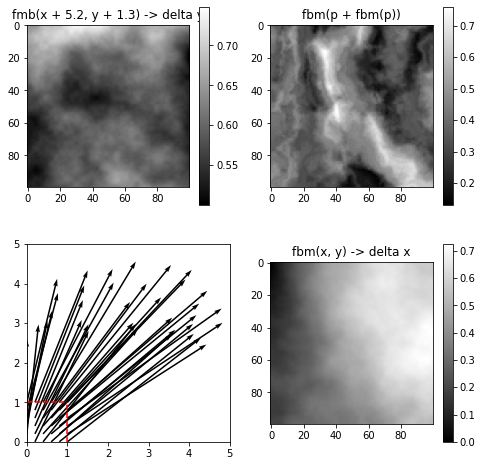

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# iteration times
OCTAVES = 8

# color mapping
cmap = LinearSegmentedColormap.from_list("xxx", list(zip([0, 1], ["black", "white"])))

def mix(a, b, x):
    return a * (1 - x) + b * x

def rand(s, t):
    fract = lambda x: x - np.floor(x)
    return fract(np.sin(s * 12.9898 + t * 78.233) * 43758.5453123)

def noise(s, t):
    i_s, i_t = np.floor(s), np.floor(t)
    f_s, f_t = s - i_s, t - i_t

    # four corner point of grid
    a = rand(i_s, i_t)
    b = rand(i_s + 1, i_t)
    c = rand(i_s, i_t + 1)
    d = rand(i_s + 1, i_t + 1)

    # hermit interpolation factor
    s_inter = f_s ** 2 * (3 - 2 * f_s)
    t_inter = f_t ** 2 * (3 - 2 * f_t)

    return mix(
        mix(a, b, s_inter),
        mix(c, d, s_inter), t_inter
    )

def fbm(s, t):
    x, y = s * 1, t * 1
    data = np.repeat(0.0, s.size).reshape(s.shape)

    amplitude = 0.5

    for _ in range(OCTAVES):
        data += amplitude * noise(x, y)

        # halve amplitude, double frequency
        amplitude *= 0.5
        x *= 2.0
        y *= 2.0

    return data

fig = plt.figure(figsize=(8, 8))

x1, y1 = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# fbm(x, y) -> delta x
ax1 = fig.add_subplot(224)
psm1 = ax1.imshow(fbm(x1, y1), cmap=cmap)
ax1.set_title("fbm(x, y) -> delta x")
fig.colorbar(psm1, ax=ax1)

# fmb(x + 5.2, y + 1.3) -> delta y
ax2 = fig.add_subplot(221)
psm2 = ax2.imshow(fbm(x1 + 5.2, y1 + 1.3), cmap=cmap)
ax2.set_title("fmb(x + 5.2, y + 1.3) -> delta y")
fig.colorbar(psm2, ax=ax2)

x2, y2 = np.meshgrid(np.linspace(0, 1, 6), np.linspace(0, 1, 6))
u, v = x2 + 4.0 * fbm(x2, y2), y2 + 4.0 * fbm(x2 + 5.2, y2 + 1.3)

# quiver
ax3 = fig.add_subplot(223)
ax3.quiver(x2, y2, u, v, scale=1, scale_units="xy")
ax3.axis([0, 5, 0, 5])
ax3.axvline(1, 0, 1/5, ls="--", color="r")
ax3.axhline(1, 0, 1/5, ls="--", color="r")

# result
ax4 = fig.add_subplot(222)
psm4 = ax4.imshow(fbm(
    x1 + 6.0 * fbm(x1, y1),
    y1 + 8.0 * fbm(x1 + 5.2, y1 + 1.3)
), cmap=cmap)
ax4.set_title("fbm(p + fbm(p))")
fig.colorbar(psm4, ax=ax4)

对上图的解释：

- 第一幅和第四幅图表示 $[0, 1]^2$ 中的点在 $y$ 方向和 $x$ 方向的位置偏移值
- 第三副图用向量表示这个位置偏移函数 $p' = g(p)$ 
- 第二幅图是应用位置偏移后，得到的 `fbm` 波形图

最开始是这样：
$$
p =
\left\{
    \begin{array}{l}
        p_x \\ p_y
    \end{array}
\right.
$$

还可以进一步对位置进行偏移：
$$
p'=
\left\{
    \begin{array}{l}
        p_x + 4 \times fbm(p + (0.0, 0.0))\\
        p_y + 4 \times fbm(p + (5.2, 1.3))
    \end{array}
\right.
$$

进一步即为：
$$
p'' = 
\left\{
    \begin{array}{l}
        p_x + 4 \times fbm(p' + (1.7, 9.2)) \\
        p_y + 4 \times fbm(p' + (8.3, 2.8))
    \end{array}
\right.
$$

最后得到如下效果：

Text(0.5, 1.0, 'f(p) = fbm(p + fbm(p + fbm(p)))')

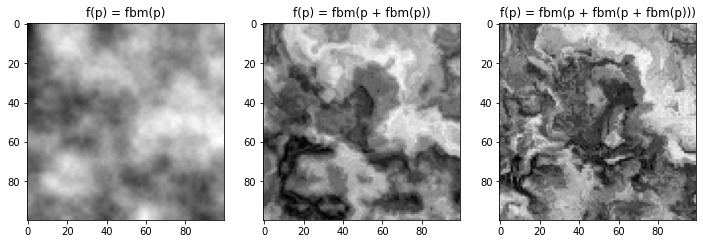

In [7]:
fig = plt.figure(figsize=(12, 4))

# f(p) = fbm(p)
p_x, p_y = np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100))
ax1 = fig.add_subplot(131)
ax1.imshow(fbm(p_x, p_y), cmap=cmap)
ax1.set_title("f(p) = fbm(p)")

# f(p) = fbm(p + fbm(p))
p1_x = p_x + 4.0 * fbm(p_x, p_y)
p1_y = p_y + 4.0 * fbm(p_x + 5.2, p_y + 1.3)
ax2 = fig.add_subplot(132)
ax2.imshow(fbm(p1_x, p1_y), cmap=cmap)
ax2.set_title("f(p) = fbm(p + fbm(p))")

# f(p) = fbm(p + fbm(p + fbm(p)))
p2_x = p_x + 4.0 * fbm(p1_x + 1.7, p1_y + 9.2)
p2_y = p_y + 4.0 * fbm(p1_x + 8.3, p1_y + 2.8)
ax3 = fig.add_subplot(133)
ax3.imshow(fbm(p2_x, p2_y), cmap=cmap)
ax3.set_title("f(p) = fbm(p + fbm(p + fbm(p)))")